In [1]:
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
import re, unicodedata, zipfile, os
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import random as rn

from gensim.models import KeyedVectors
from collections import Counter
import itertools

Using Theano backend.


In [2]:
def train_test_split(X, y, test_size, random_state=42, shuffle=False):
    test_indexes, train_indexes = [], []
    np.random.seed(random_state)
    for class_ in np.unique(y):    
        N = y[y == class_].value_counts().values[0]
        part = int(round(N * test_size))

        full_indexes = np.array(y[y == class_].index)
        low = full_indexes.min()
        high = full_indexes.max()

        temp = np.random.randint(low, high, part)
        test_indexes.extend(temp)

        temp = np.delete(full_indexes, test_indexes)
        train_indexes.extend(temp)
        
    if shuffle is True:
        np.random.shuffle(train_indexes)
        np.random.shuffle(test_indexes)
        
    X_train = X.iloc[train_indexes]
    y_train = y.iloc[train_indexes]
    X_test = X.iloc[test_indexes]
    y_test = y.iloc[test_indexes]
    return X_train, X_test, y_train, y_test

## Generating and preprocessing data
Books are read from zip-files, text is cleaned from stop-words and lemmatized with nltk.WordNetLemmatizer()

In [3]:
def generate_dataframe(folders, root):
    data = pd.DataFrame()
    for folder in folders:
        path = root+'/'+folder
        data = data.append(pd.DataFrame({'text': read_zip_files(path), 'target':folder}), ignore_index=True)
    return data

def read_zip_files(path):
    text_list = []
    for archive in os.listdir(path):
        file = zipfile.ZipFile(path+'/'+archive)
        b_text = file.open(file.namelist()[0]).readlines()
        text_list.append(b_text)
    return text_list

def decoding(text):
    decoded = [row.decode("utf-8", errors='ignore').splitlines() for row in text]
    splited = [[' '.join(item.split())] for row in decoded for item in row]
    cleaned = [row for row in splited if row != ['']]
    return cleaned

def cleaning(text):
    cleaned_text = re.sub(r"[^a-z ]", " ", text.lower())
    return cleaned_text

def stop_words(row):
    stop = stopwords.words('english')
    new_row = [word for word in row if word not in stop]
    return new_row

def ascii_cleaning(row):
    new_row = [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in row]
    return new_row

def lemmatization(row):
    lemmatizer = WordNetLemmatizer()
    new_row = [lemmatizer.lemmatize(word, pos='v') for word in row]
    return new_row

def list_to_text(text):
    new_text = [' '.join(row) for row in text]
    return ' '.join(new_text)

def delete_words(df):
    df['text'] = df['text'].apply(lambda document: list(filter(lambda word: re.fullmatch(r'[a-z]{2,}', word), document)))
    
def split_for_bayes(df):
    df['text'] = df['text'].apply(lambda x: x.split())
    return

def preproc(df):
    df['text'] = df['text'].apply(lambda x: decoding(x))
    df['text'] = df['text'].apply(lambda x: [cleaning(row[0]) for row in x])
    df['text'] = df['text'].apply(lambda x: [stop_words(list(row.split())) for row in x])
    df['text'] = df['text'].apply(lambda x: [ascii_cleaning(row) for row in x])
    df['text'] = df['text'].apply(lambda x: [lemmatization(row) for row in x])
    df['text'] = df['text'].apply(lambda x: list_to_text(x))

In [4]:
root_folder = 'data/zip'
data = generate_dataframe(os.listdir(root_folder), root_folder)
preproc(data)

DataFrame is splited to X and y

In [5]:
X = data['text']
y = data['target']

Classes that I used:

In [7]:
for c in np.unique(y):
    print(c)

drama
erotic
religion
songs
teacher


## Preparing data for Neural Network

One-hot encoding for y-vector

In [8]:
sentences_train, sentences_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1110, shuffle=True)
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y_train)
y_train = np_utils.to_categorical(encoded_Y)
encoded_Y = encoder.transform(y_test)

y_test = np_utils.to_categorical(encoded_Y)

Now prepare X-matrix, converting text to word vectors

In [9]:
tokenizer = Tokenizer(num_words=70000)
tokenizer.fit_on_texts(X)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200
maxlen = 5000

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [10]:
def dnn():
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])#, precision, recall, f1])
    model.summary()
    return model

In [11]:
model = dnn()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 200)         11264200  
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1005      
Total params: 11,305,405
Trainable params: 11,305,405
Non-trainable params: 0
_________________________________________________________________


In [12]:
np.random.seed(42)
history = model.fit(X_train, y_train,
                    epochs=25,
                    verbose=True,
                    validation_split=0.2,
                    batch_size=10)

Train on 77 samples, validate on 20 samples
Epoch 1/25
77/77 [==============================] - 5s 68ms/step - loss: 1.5729 - acc: 0.2727 - val_loss: 1.5784 - val_acc: 0.2500
Epoch 2/25
77/77 [==============================] - 5s 65ms/step - loss: 1.5058 - acc: 0.2987 - val_loss: 1.5652 - val_acc: 0.2500
Epoch 3/25
77/77 [==============================] - 5s 70ms/step - loss: 1.4627 - acc: 0.2987 - val_loss: 1.5534 - val_acc: 0.2500
Epoch 4/25
77/77 [==============================] - 5s 67ms/step - loss: 1.4313 - acc: 0.5844 - val_loss: 1.5556 - val_acc: 0.2500
Epoch 5/25
77/77 [==============================] - 5s 66ms/step - loss: 1.4133 - acc: 0.3766 - val_loss: 1.5508 - val_acc: 0.2500
Epoch 6/25
77/77 [==============================] - 5s 67ms/step - loss: 1.3847 - acc: 0.5065 - val_loss: 1.5369 - val_acc: 0.5000
Epoch 7/25
77/77 [==============================] - 5s 71ms/step - loss: 1.3574 - acc: 0.6234 - val_loss: 1.5144 - val_acc: 0.5000
Epoch 8/25
77/77 [=====================

### Here the results of Neural Network training

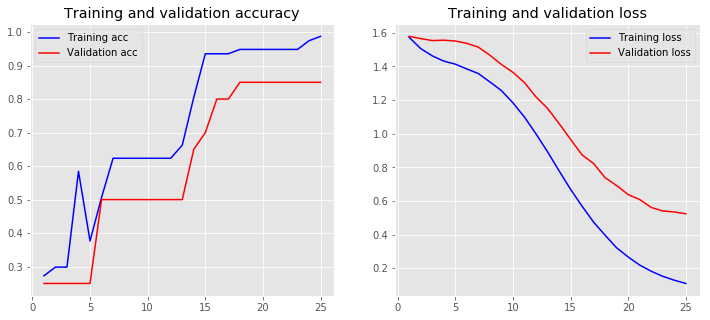

In [14]:
plot_history(history)

### Metrics and Confusion matrix:

Testing Accuracy:  0.9583
Testing Precision:  0.9635
Testing Recall:  0.9583
Testing F1:  0.9583


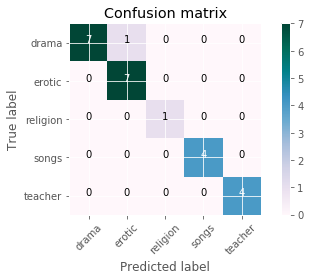

In [19]:
get_confusion_matrix_metrics(y_test, model.predict(X_test))   

In [13]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [15]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.PuBuGn):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

In [16]:
def get_confusion_matrix_metrics(y_test, y_pred):
    def get_one_hot(y_softmax):
        y_pred = np.zeros_like(y_softmax, dtype=int)
        for i in range(len(y_pred)):
            target = max(y_softmax[i])
            for j in range(len(y_pred[i])):
                if y_softmax[i][j]==target:
                    y_pred[i][j] = 1
        return y_pred

    y_pred_2 = get_one_hot(y_pred)
    
    y_pred_3 = np.argmax(y_pred_2, axis=1)
    y_pred_4 = encoder.inverse_transform(y_pred_3)
    
    y_test_3 = np.argmax(y_test, axis=1)
    y_test_4 = encoder.inverse_transform(y_test_3)
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    print("Testing Precision:  {:.4f}".format(precision_score(y_test_3, y_pred_3, average='weighted')))
    print("Testing Recall:  {:.4f}".format(recall_score(y_test_3, y_pred_3, average='weighted')))
    print("Testing F1:  {:.4f}".format(f1_score(y_test_3, y_pred_3, average='weighted')))
    
    plot_confusion_matrix(confusion_matrix(y_test_4, y_pred_4), np.unique(y_test_4))
    

## Naive Bayes Classifier

### Converting document's text to lists of words

In [20]:
split_for_bayes(data)

In [21]:
X = data['text']
y = data['target']

In [22]:
class NaiveBayesClassifier():
    
    def fit(self, X, y):
        doc_counter = Counter(y)
        total_doc = len(y)
        self.classes = list(set(doc_counter))
        
        self.doc_frequency = {}
        for c_i in self.classes:
            self.doc_frequency[c_i] = np.log(doc_counter[c_i] / total_doc)
            
        self.word_frequency = {c_i: Counter([w_i for d_i in X[y == c_i] for w_i in d_i]) \
                                                                                    for c_i in self.classes}

        self.total_uniq_word = len(list(set([w_i for c_j in \
                                             [list(self.word_frequency[c_i]) for c_i in self.word_frequency] \
                                             for w_i in c_j])))
        self.words_in_class = {c_i: sum(list(self.word_frequency[c_i].values())) for c_i in self.word_frequency}        
            
    def tf_idf_compute(self, frequency):
        self.tf = {}
        for c_i in self.classes:
            self.tf[c_i] = Counter()
            N = sum(list(frequency[c_i].values()))
            for w_i in frequency[c_i]:
                self.tf[c_i][w_i] = frequency[c_i][w_i]/float(N)
                self.tf[c_i][w_i] *= np.log(len(self.classes)/sum([1 for c_j in self.classes if w_i in frequency[c_j]]))
    
    def predict(self, X_test):
        prediction = pd.DataFrame(columns=self.classes, index=X_test.index)
        for i in X_test.index:
            for c_i in self.classes:
                prediction.loc[i][c_i] = self.doc_frequency[c_i] + \
                sum([np.log((self.word_frequency[c_i][w_i] + 1) / \
                            (self.total_uniq_word + self.words_in_class[c_i])) for w_i in X_test.loc[i]])
        
        return prediction
    
    def accuracy(self, y, prediction):
        return sum([1 for i in prediction.index \
            if y.loc[i] == list(prediction.loc[i][prediction.loc[i] == max(prediction.loc[i])].index.values)[0]])\
            / y.shape[0]

### Using Stratified K-Fold cross validation

In [24]:
str_kf = StratifiedKFold(n_splits=4, random_state=7, shuffle=True)
result = {'y': [], 'predict': []}
for train_index, test_index in str_kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    nbc = NaiveBayesClassifier()
    nbc.fit(X_train, y_train)
    predicted = nbc.predict(X_test)
    result['y'].append(y_test)
    result['predict'].append(predicted)
acc = []
for i in range(len(result['y'])):
    acc.append(nbc.accuracy(result['y'][i], result['predict'][i]))

### Here the average accuracy...

In [25]:
print('Accuracy of NaiveBayes is {:.4f}'.format(sum(acc)/len(acc)))

Accuracy of NaiveBayes is 0.9087


In [26]:
def show_results(r):
    matrixes = []
    metrics = []
    for i in range(len(r['y'])):
        matrixes.append(confusion_matrix(r['y'][i], probability_to_class(r['predict'][i])))
        metrics.append(calculate_metrics(matrixes[i], np.unique(r['y'][i])))
    
    return matrixes, metrics

def calculate_metrics(confusion_matrix, classes):
    metrics = {'precision': [], 
               'recall': [],
               'f1': [],}
    for i, col in enumerate(confusion_matrix.columns):
        metrics['precision'].append(confusion_matrix.iloc[i][col] / sum(confusion_matrix[col])) \
                if sum(confusion_matrix[col]) != 0 else metrics['precision'].append(0)
        metrics['recall'].append(confusion_matrix.iloc[i][col] / sum(confusion_matrix.iloc[i]))
        if metrics['precision'][i] + metrics['recall'][i] != 0:
            metrics['f1'].append(2.0 * (metrics['precision'][i] * metrics['recall'][i]) / 
                                 (metrics['precision'][i] + metrics['recall'][i]))
        else:
            metrics['f1'].append(0)
    return pd.DataFrame(data=metrics, index=classes)

def probability_to_class(prediction):
    prediction_class = pd.Series(index=prediction.index)
    for i in prediction.index:
        prediction_class.loc[i] = list(prediction.loc[i][prediction.loc[i] == max(prediction.loc[i])].index.values)[0]
    return prediction_class

def confusion_matrix(y_actual, y_predicted):# both Series type
    classes = np.unique(y_actual)
    matrix = pd.DataFrame(columns=classes, index=classes)
    for actual_class in classes:
        for predicted_class in classes:
            matrix.loc[actual_class][predicted_class] = len(y_actual[(y_actual==actual_class) & 
                                                                     (y_predicted==predicted_class)])
    indexes = ['Actual_'+i for i in classes]
    columns = ['Predicted_'+c for c in classes]
    matrix.index = indexes
    matrix.columns = columns
    return matrix

In [27]:
cm, mt = show_results(result)

### ... and other results. Confusion matrixes...

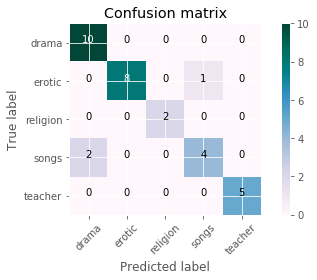

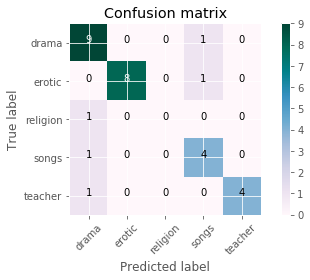

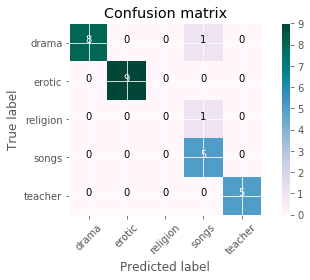

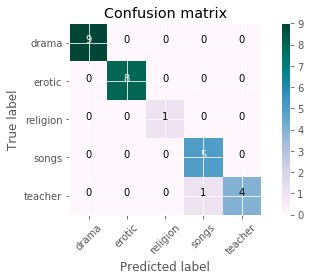

In [28]:
for i in cm:
    plot_confusion_matrix(np.array(i.values, dtype=int), np.unique(y))

### ... and metrics - Precision, Recall, F1

In [29]:
mt[0].style.background_gradient(cmap='winter')

,precision,recall,f1
drama,0.833333,1,0.909091
erotic,1,0.888889,0.941176
religion,1,1,1
songs,0.8,0.666667,0.727273
teacher,1,1,1


In [30]:
mt[1].style.background_gradient(cmap='winter')

,precision,recall,f1
drama,0.75,0.9,0.818182
erotic,1,0.888889,0.941176
religion,0,0,0
songs,0.666667,0.8,0.727273
teacher,1,0.8,0.888889


In [31]:
mt[2].style.background_gradient(cmap='winter')

,precision,recall,f1
drama,1,0.888889,0.941176
erotic,1,1,1
religion,0,0,0
songs,0.714286,1,0.833333
teacher,1,1,1


In [32]:
mt[3].style.background_gradient(cmap='winter')

,precision,recall,f1
drama,1,1,1
erotic,1,1,1
religion,1,1,1
songs,0.833333,1,0.909091
teacher,1,0.8,0.888889


## Conclusion

Deep Neural Network shows the best results, its metrics are higher than Naive Bayes's, but NN is more sentitive to the data. Both models had problems with classes, which have the least number of documents.